In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_base_dir = '../../../datasets/Movielens/'
# data_dir = data_base_dir + 'serendipity-sac2018/'
data_dir = data_base_dir + 'ml-20m/'

genome_scores = data_dir + 'genome-scores.csv'
genome_tags = data_dir + 'genome-tags.csv'
movies = data_dir + 'movies.csv'
ratings = data_dir + 'ratings.csv'
# ratings = data_dir + 'training.csv'
tags = data_dir + 'tags.csv'
# answers = data_dir + 'answers.csv'

genomes_df = pd.read_csv(genome_scores).pivot(index='movieId', columns='tagId', values='relevance')
genome_score_movies = genomes_df.index.values
ratings_df = pd.read_csv(ratings, usecols=range(3), dtype={'userId':np.int64, 'movieId':np.int64, 'rating':np.float64}, low_memory=False)
ratings_df = ratings_df[ratings_df['movieId'].isin(genome_score_movies)]
ratings_df

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5
5,1,112,3.5
6,1,151,4.0
7,1,223,4.0
8,1,253,4.0
9,1,260,4.0


In [2]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from time import time
    
def get_users_best_silhouette_score(user_id, genome_scores_df):
    user_movie_tags_df = pd.DataFrame()
    user_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values
    user_movie_tags_df = genome_scores_df[genome_scores_df.index.isin(user_movies)]
    n_movies = user_movie_tags_df.index.size
    
    highest_score = 0
    optimal_cluster_size = 2

    user_movies_matrix = np.nan_to_num(user_movie_tags_df.values[:n_movies])
    
    for cluster_size in range(2, n_movies-1, 1):
        result = AgglomerativeClustering(n_clusters=cluster_size, affinity='euclidean', linkage='ward').fit_predict(user_movies_matrix)
        score = silhouette_score(user_movies_matrix, result, metric='euclidean')
#         cluster_size_silhouette_score_d[cluster_size] = score
        
        if score >= highest_score:
            highest_score = score
            optimal_cluster_size = cluster_size
    
    return highest_score, optimal_cluster_size
            
def get_best_silhouette_score_for_all_movies(genome_scores_df, start_size, end_size, step_size):
    start_time = time()
    score_history = []
    cluster_size_hist = []
    best_score = -1
    best_cluster_size = 0
    
    for cluster_size in range(start_size, end_size, step_size):
#         result = KMeans(n_clusters=cluster_size, random_state=171450, n_jobs=-1).fit_predict(genome_scores_df.values)
        result = AgglomerativeClustering(n_clusters=cluster_size, affinity='euclidean', linkage='ward').fit_predict(genome_scores_df.values)

        score = silhouette_score(genome_scores_df.values, result, metric='euclidean')
        
        score_history.append(score)
        cluster_size_hist.append(cluster_size)
        
        if best_score < score:
            best_score = score
            best_cluster_size = cluster_size
    
    finish_time = time() - start_time
    print('Total time taken: %f seconds' % finish_time)
    return score_history, cluster_size_hist, best_score, best_cluster_size

In [3]:
def get_all_users_mean_best_scores(genomes_df, test_users):
    plt.clf()
    score_history = list()
    optimal_cluster_size_hist = list()

    best_user = 0
    best_score = 0

    for user in test_users:
        highest_score, optimal_cluster_size = get_users_best_silhouette_score(user, genomes_df)
        score_history.append(highest_score)

        if best_score < highest_score:
            best_score = highest_score
            best_user = user

        optimal_cluster_size_hist.append(optimal_cluster_size)
    
    print('highest_score', best_score)
    print('best_user', best_user)

    return np.array(score_history).mean()

In [4]:
tag_genome_df = pd.read_csv(genome_scores).pivot(index='movieId', columns='tagId', values='relevance')

def get_results_for_all_dfs(test_users):
    genome_df_list = [tag_genome_df, 'movies_lemmatized_genome_vector_df_bz2',\
                'threshold_0.25_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.25_float_movie_genomes_bz2',\
#                 'threshold_0.3_float_movie_genomes_bz2', \
#                 'movies_lemmatized_threshold_0.3_float_movie_genomes_bz2',\
#                 'threshold_0.35_float_movie_genomes_bz2', \
#                 'movies_lemmatized_threshold_0.35_float_movie_genomes_bz2',\
                'threshold_0.4_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.4_float_movie_genomes_bz2', \
#                 'threshold_0.6_float_movie_genomes_bz2',\
#                 'movies_lemmatized_threshold_0.6_float_movie_genomes_bz2', \
                'threshold_0.7_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.7_float_movie_genomes_bz2']
    df_names = ['full_genomes', 'movies_lemmatized_genome_vector_df_bz2',\
                'threshold_0.25_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.25_float_movie_genomes_bz2',\
#                 'threshold_0.3_float_movie_genomes_bz2', \
#                 'movies_lemmatized_threshold_0.3_float_movie_genomes_bz2',\
#                 'threshold_0.35_float_movie_genomes_bz2', \
#                 'movies_lemmatized_threshold_0.35_float_movie_genomes_bz2',\
                'threshold_0.4_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.4_float_movie_genomes_bz2', \
#                 'threshold_0.6_float_movie_genomes_bz2',\
#                 'movies_lemmatized_threshold_0.6_float_movie_genomes_bz2', \
                'threshold_0.7_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.7_float_movie_genomes_bz2']

    scores_df = pd.DataFrame()

    for index, genomes_df in enumerate(genome_df_list):
        print('processing for: ', df_names[index])
        if type(genomes_df) is str:
            genomes_df = pd.read_pickle(data_dir + 'output/' + genomes_df, compression='bz2')

        mean_best_score = get_all_users_mean_best_scores(genomes_df, test_users)
        print('mean_best_score', mean_best_score, '\n')
        ser = pd.Series()
        ser.name = df_names[index]
        ser['mean_best_score'] = mean_best_score
        scores_df = scores_df.append(ser)

    scores_df.plot(kind='barh')

In [11]:
from time import time

def get_movie_results_for_all_dfs(start_size, end_size, step_size=5):
    start_time = time()
    genome_df_list = [tag_genome_df, 'movies_lemmatized_genome_vector_df_bz2',\
                'threshold_0.25_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.25_float_movie_genomes_bz2',\
                'threshold_0.4_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.4_float_movie_genomes_bz2', \
                'threshold_0.7_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.7_float_movie_genomes_bz2']
    
    df_names = ['full_genomes', 'movies_lemmatized_genome_vector_df_bz2',\
                'threshold_0.25_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.25_float_movie_genomes_bz2',\
                'threshold_0.4_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.4_float_movie_genomes_bz2', \
                'threshold_0.7_float_movie_genomes_bz2', \
                'movies_lemmatized_threshold_0.7_float_movie_genomes_bz2']

    scores_df = pd.DataFrame()
    
    for index, genomes_df in enumerate(genome_df_list):
        df_start_time = time()
        print('processing for: ', df_names[index])
        if type(genomes_df) is str:
            genomes_df = pd.read_pickle(data_dir + 'output/' + genomes_df, compression='bz2')
        
        score_history, cluster_size_hist, best_score, best_cluster_size = get_best_silhouette_score_for_all_movies(genomes_df, start_size, end_size, step_size)
    
        df_finish_time = time() - df_start_time
        print("Total time taken for DF %s" % df_names[index] +  " - %f seconds" % df_finish_time)
        scores_df[str(df_names[index])] = score_history
#         plt.title('Mean best Silhouette Scores - DF_' + str(df_names[index]))
#         plt.plot(score_history)
#         plt.show()

    scores_df.plot(title='Silhouette Scores for all DFs')
    plt.show()
    finish_time = time() - start_time
    print("Total time taken: %f seconds" % finish_time)

        #     scores_df = pd.DataFrame()

#     for index, genomes_df in enumerate(genome_df_list):
#         print('processing for: ', df_names[index])
#         if type(genomes_df) is str:
#             genomes_df = pd.read_pickle(data_dir + 'output/' + genomes_df, compression='bz2')

#         mean_best_score = get_all_users_mean_best_scores(genomes_df, test_users)
#         print('mean_best_score', mean_best_score, '\n')
#         ser = pd.Series()
#         ser.name = df_names[index]
#         ser['mean_best_score'] = mean_best_score
#         scores_df = scores_df.append(ser)

#     scores_df.plot(kind='barh')

In [11]:
start_size=2
end_size=110
step_size=5
score_history, cluster_size_hist, best_score, best_cluster_size = get_best_silhouette_score_for_all_movies(tag_genome_df, start_size, end_size, step_size)

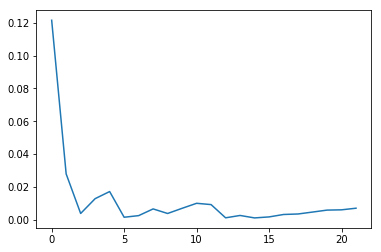

In [12]:
plt.plot(score_history)

In [16]:
score_history

[0.12156554256311558,
 0.027904847457420147,
 0.0038049914074617156,
 0.012832129698978354,
 0.017164240128317496,
 0.0014995686348714726,
 0.002485311313886313,
 0.006571695182067329,
 0.003793532331508517,
 0.006947035993117187,
 0.009999674667695914,
 0.009209395259539649,
 0.0011501590025530146,
 0.002589752624897339,
 0.0010910523665274203,
 0.00170221956167518,
 0.003182763500850032,
 0.0034916273918898155,
 0.004661238522918558,
 0.00584979205949351,
 0.0060215180919143485,
 0.007009845436935289]

In [17]:
cluster_size_hist

[2,
 7,
 12,
 17,
 22,
 27,
 32,
 37,
 42,
 47,
 52,
 57,
 62,
 67,
 72,
 77,
 82,
 87,
 92,
 97,
 102,
 107]

In [ ]:
start_size=2
end_size=5
step_size=1
get_movie_results_for_all_dfs(start_size, end_size, step_size)

processing for:  full_genomes
Total time taken: 117.054599 seconds
Total time taken for DF full_genomes - 117.054747 seconds
processing for:  movies_lemmatized_genome_vector_df_bz2
Total time taken: 85.253168 seconds
Total time taken for DF movies_lemmatized_genome_vector_df_bz2 - 87.029821 seconds
processing for:  threshold_0.25_float_movie_genomes_bz2


In [ ]:
plt.plot(score_history)